In [2]:
import mdtraj as md
import bpmfwfft.grids as grids
import numpy as np

In [17]:
from os import walk
import socket
if socket.gethostname() == 'jim-Mint':
    ppi_path = '/media/jim/Research_TWO/FFT_PPI'
    home = '/home/jim'
else:
    ppi_path = '/home/jtufts/Desktop/FFT_PPI'
    home = '/home/jtufts'

In [3]:
f = {}
for (dirpath, dirnames, filenames) in walk(f'{ppi_path}/2.redock/2.minimize'):
    if filenames[0] != 'run_me.sh':
        if 'complex.pdb' in filenames:
            f[dirpath.split('/')[7]] = dirpath + '/complex.pdb'

In [44]:
import netCDF4 as nc
import numpy as np

grid_path = f'{ppi_path}/2.redock/4.receptor_grid/2OOB_A:B'
grid_nc = '%s/grid.nc'%grid_path


#parsing some of the netcdf variables from grid.nc
grid_variables = nc.Dataset(grid_nc, 'r').variables
counts = nc.Dataset(grid_nc, 'r').variables["counts"][:]
x = nc.Dataset(grid_nc, 'r').variables["x"][:]
y = nc.Dataset(grid_nc, 'r').variables["y"][:]
z = nc.Dataset(grid_nc, 'r').variables["z"][:]
electrostatic = nc.Dataset(grid_nc, 'r').variables["electrostatic"][:]
lja = nc.Dataset(grid_nc, 'r').variables["LJa"][:]
ljr = nc.Dataset(grid_nc, 'r').variables["LJr"][:]
sasai = nc.Dataset(grid_nc, 'r').variables["SASAi"][:]
sasar = nc.Dataset(grid_nc, 'r').variables["SASAr"][:]
trans_crd = nc.Dataset(grid_nc, 'r').variables["trans_crd"][:]
rec_disp = nc.Dataset(grid_nc, 'r').variables["displacement"][:]

In [45]:
from bpmfwfft.grids import RecGrid
from bpmfwfft.grids import LigGrid

rec_prmtop = f"{ppi_path}/2.redock/1.amber/2OOB_A:B/receptor.prmtop"
lj_sigma_scal_fact = 1.0
rec_inpcrd = f"{ppi_path}/2.redock/2.minimize/2OOB_A:B/receptor.inpcrd"

bsite_file = None
grid_nc_file = f"{ppi_path}/2.redock/4.receptor_grid/2OOB_A:B/grid.nc"

lig_prmtop = f"{ppi_path}/2.redock/1.amber/2OOB_A:B/ligand.prmtop"
# lig_inpcrd = f"{ppi_path}/2.redock/2.minimze/2OOB_A:B/ligand.inpcrd"

rot_nc = f"{ppi_path}/2.redock/3.ligand_rand_rot/2OOB_A:B/rotation.nc"
lig_rot = nc.Dataset(rot_nc, 'r').variables['positions']
lig_inpcrd = f"{ppi_path}/2.redock/2.minimize/2OOB_A:B/ligand.inpcrd"

rho = 9.0
rc_scale = 0.76
rs_scale = 0.53
rm_scale = 0.55
lc_scale = 0.81
ls_scale = 0.50
lm_scale = 0.54


def _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file):
    rec_grid = RecGrid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, 
                        grid_nc_file, new_calculation=False)
    return rec_grid

def _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid):
    lig_grid = LigGrid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
    return lig_grid

rec_grid = _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file)

lig_grid = _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)

lig_grid._crd = np.array(lig_rot[0], dtype=np.float64)
lig_grid._move_ligand_to_lower_corner()

/home/jim/src/p39/fftanalysis
[1.]
/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/2OOB_A:B/grid.nc
[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  7

In [46]:
names = ["SASA"]
lgrid = lig_grid.get_ligand_grids(names, [0,0,0])

In [47]:
import numpy as np
rgrid = np.add(sasar, sasai*1.j)

In [8]:
print((lgrid["SASA"]*rgrid).sum())

0j


In [9]:
lgrid_trans = grids.translate_grid(lgrid["SASA"], np.array([68,87,45]))

In [10]:
print((lgrid_trans*rgrid).sum())

(551+0j)


In [71]:
# fft test
lfft = np.fft.fftn(lgrid["SASA"].conjugate())
rfft = np.fft.fftn(rgrid)
cfft = np.fft.ifftn(rfft*lfft.conjugate())
score = np.real(cfft) - np.imag(cfft)*1000000

In [49]:
def rmsd(P: np.ndarray, Q: np.ndarray, **kwargs) -> float:
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation between the two vectors
    """
    diff = P - Q
    return np.sqrt((diff * diff).sum() / P.shape[0])

In [72]:
import copy
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([68,87,45])*lig_grid._spacing)
ref = copy.deepcopy(lig_grid._crd)
lig_grid._move_ligand_to_lower_corner()
lig_grid.translate_ligand(np.array([69,87,45])*lig_grid._spacing)
tar = copy.deepcopy(lig_grid._crd)

print("rmsd", rmsd(ref, tar))

Ligand translated by [-33.5 -44.  -24.5]
[1.14105129 1.36711311 1.38056588]
Ligand translated by [-34.  -43.5 -22.5]
[1.14105129 1.36711311 1.38056588]
rmsd 0.5


In [73]:
print(np.amax(score))
k = 200  # number of scores to save
flat_score = score.flatten()
flat_argp = np.argpartition(flat_score, -k)[-k:]

1386.0000002326615


In [74]:
top_scores = flat_score[flat_argp]
top_scores.sort()
translations = []
trans_scores = []

for score_val in top_scores:
    t = np.where(score == score_val)
    a = np.array(t)
    if a.shape == (3,2):
        for x,y,z in a.transpose():
            x = np.array([x])
            y = np.array([y])
            z = np.array([z])
            translations.append((x,y,z))
            trans_scores.append(score[x,y,z])
            # print((x,y,z),  score[x,y,z], cfft[x,y,z])
    else:
        translations.append(t)
        trans_scores.append(score[t])
        # print(t, score[t], cfft[t])

In [ ]:
def cat_grids(grid1, grid2):
    prmtop = cat_dictionaries(grid1._prmtop,grid2._prmtop)
    crd = cat_dictionaries(grid1._crd,grid2._crd)
    cat_grid = copy.deepcopy(grid1)
    cat_grid._prmtop = prmtop
    cat_grid._crd = crd
    return cat_grid

def cat_dictionaries(dict1, dict2):
    dict1_copy = copy.deepcopy(dict1)
    dict2_copy = copy.deepcopy(dict2)
    
    if isinstance(dict1_copy, dict):
        keys = list(dict1_copy.keys())
        for key in keys:
            # print(keys)
            # print(key)
            dict1_copy[key] = cat_values(dict1[key], dict2[key])
        return dict1_copy
    
    elif isinstance(dict1_copy, np.ndarray):
        return np.concatenate((dict1_copy,dict2_copy))

def cat_values(a1, a2):
    array1 = copy.deepcopy(a1)
    array2 = copy.deepcopy(a2)
    if isinstance(array1, np.ndarray):
        return np.concatenate((array1,array2))
    elif isinstance(array1, dict):
        return cat_dictionaries(array1, array2)
    elif isinstance(array1, (int, np.int64)):
        # print(f"{array1+array2}")
        return array1 + array2
    elif isinstance(array1, list):
        # print(type(array1))
        # print(f'array1:{len(array1)}, array2:{len(array2)}')
        array1.extend(array2)
        # print(f'complex:{len(array1)}, sum:{len(a1)+len(a2)}')
        return array1

        
        
import copy
# result = map(cat_dictionaries, rec_grid._prmtop, lig_grid._prmtop)
delta_sasas = []
colors = []
for v,vector in enumerate(translations):
    vector = (np.array(vector).transpose()*lig_grid._spacing)[0]
    lig_grid._move_ligand_to_lower_corner()
    print(vector)
    lig_grid.translate_ligand(vector)
    com_grid = cat_grids(rec_grid, lig_grid)
    c_sasa = com_grid._get_molecule_sasa(0.14, 960).sum()
    l_sasa = lig_grid._get_molecule_sasa(0.14, 960).sum()
    r_sasa = rec_grid._get_molecule_sasa(0.14, 960).sum()
    d_sasa = (l_sasa + r_sasa) - c_sasa
    delta_sasas.append(d_sasa)
    rmsd_to_native = rmsd(ref, lig_grid._crd)
    if rmsd_to_native < 5.:
        # colors.append([255, 0, 0])
        colors.append("red")
    else:
        # colors.append([0, 255, 255])
        colors.append("black")
        
    print(c_sasa, l_sasa + r_sasa, d_sasa)
    com_grid.write_pdb(f'{home}/Desktop/translations/com/trans{v}.pdb', "w")
    lig_grid.write_pdb(f'{home}/Desktop/translations/lig/trans{v}.pdb', "w")
    rec_grid.write_pdb(f'{home}/Desktop/translations/lig/rec.pdb', "w")


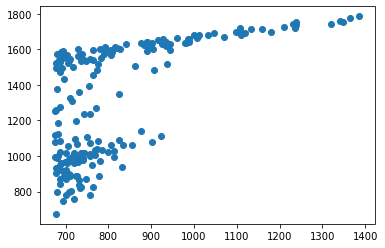

In [76]:
import matplotlib.pyplot as plt
plt.scatter(trans_scores, delta_sasas)
plt.show()

In [ ]:
for u in range(len(translations)):
    print(score[translations[u]], delta_sasas[u])

In [12]:
com_grid.write_pdb('/home/jtufts/Desktop/test.pdb', "w")
com_grid.write_box('/home/jtufts/Desktop/testbox.pdb')

NATOM:2008


In [134]:
# print(cat_dictionaries(rec_grid._prmtop['POINTERS'], lig_grid._prmtop['POINTERS']))
print(com_grid._get_molecule_sasa(0.14, 960).sum())
print(lig_grid._get_molecule_sasa(0.14, 960).sum())
print(rec_grid._get_molecule_sasa(0.14, 960).sum())
print(rec_grid._get_molecule_sasa(0.14, 960).sum()+lig_grid._get_molecule_sasa(0.14, 960).sum())

7170.8086
3486.3755
4483.7715
7970.147


In [119]:
print(lig_grid._molecule_sasa.sum())

5823.7266


In [140]:
import pickle as p
f1 = np.load('/home/jtufts/Desktop/npy/delta_sasa_complex_minus_rl.npy')
f2 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/lig_sasa_sums.p', "rb"))
f3 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/rec_sasa_sums.p', "rb"))
f4 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/lig_sasas.p', "rb"))
f5 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/rec_sasas.p', "rb"))
f6 = p.load(open('/home/jtufts/src/p39/fftanalysis/data/complex_sasas.p', "rb"))
# f4

In [138]:
k2 = list(f2.keys())
k2.sort()
print(k2[127],f2[k2[127]]*100+f3[k2[127]]*100)

2OOB_A:B 7970.235824584961


In [ ]:
lig_grid._move_ligand_to_lower_corner()
ls = lig_grid._get_molecule_sasa(0.14, 960)
rs = rec_grid._get_molecule_sasa(0.14, 960)

for m,val in enumerate(f4[k2[127]][0]):
    print(val,ls[0][m])

In [ ]:
for p,l in enumerate(delta_sasas):
    print(l, f1[127]*100)

In [165]:
(rec_disp - lig_grid._displacement)/0.5

masked_array(data=[68.0, 87.0, 45.0],
             mask=[False, False, False],
       fill_value=1e+20)

In [160]:
rec_disp

masked_array(data=[40.5, 56. , 27. ],
             mask=False,
       fill_value=1e+20)

In [166]:
score[68,87,45]

591.9999999999999

In [167]:
cfft[68,87,45]

(592.0000000000001+2.326614353372607e-13j)

In [81]:
def regplot(trans_scores, delta_sasas, colors, name):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import linregress
    from sklearn.linear_model import LinearRegression

    x = np.array(trans_scores)
    y = np.array(delta_sasas)
    C = np.array(colors, dtype=str)

    change = np.where(C == 'yellow')
    C[change] = "black"

    indicies = np.where(y < 1525)
    # indicies = np.where(y == 0)

    indicies = indicies[::-1]

    for i in indicies:
        x = np.delete(x, i)
        y = np.delete(y, i)
        C = np.delete(C, i)

    indicies = np.where(x == 0)
    indicies = indicies[::-1] 

    for i in indicies:
        x = np.delete(x, i)
        y = np.delete(y, i)
        C = np.delete(C, i)

    x = x.reshape((-1,1))

    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)

    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)


    # scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, 10, c=C, alpha=0.5, marker='+',
            label="SC SCORE vs Delta SASA")
    # regression plot
    rx = np.linspace(x.min(), x.max(), 165)
    ry = model.coef_*rx + model.intercept_

    ax.plot(rx, ry, '-r', label=f'DELTA_SASA={float(model.coef_):.4f}*SC_SCORE + {float(model.intercept_):.2f}')
    plt.xlabel("SC_score")
    plt.ylabel("Delta_SASA (nm^2)")
    ax.set_title(f'R2: {r_sq}')
    ax.legend(loc='upper left')
    plt.savefig(f'{name}')

In [34]:
for i in range(9):
    # rx,ry,rz = np.random.randint(0, counts[0], 3)
    # rx = np.random.randint(19, 39, 1)
    # ry = np.random.randint(81, 101, 1)
    # rz = np.random.randint(74, 94, 1)
    rx = np.random.randint(26, 32, 1)
    ry = np.random.randint(113, 119, 1)
    rz = np.random.randint(49, 55, 1)
    lgrid_trans = grids.translate_grid(lgrid["SASA"], [rx,ry,rz])
    result = (lgrid_trans*rgrid).sum()
    print((rx,ry,rz), result, cfft[rx,ry,rz], (np.real(result)-np.imag(result)), score[rx,ry,rz])

(array([29]), array([115]), array([49])) (1324+432j) [1324.+432.j] 892.0 [892.]
(array([30]), array([115]), array([53])) (1523+837j) [1523.+837.j] 686.0 [686.]
(array([26]), array([117]), array([54])) (1295+504j) [1295.+504.j] 791.0 [791.]
(array([28]), array([114]), array([51])) (1426+738j) [1426.+738.j] 688.0 [688.]
(array([27]), array([113]), array([49])) (1281+990j) [1281.+990.j] 291.0 [291.]
(array([31]), array([114]), array([49])) (1395+756j) [1395.+756.j] 639.0 [639.]
(array([28]), array([116]), array([52])) (1363+234j) [1363.+234.j] 1129.0 [1129.]
(array([30]), array([117]), array([50])) (1251+216j) [1251.+216.j] 1035.0 [1035.]
(array([31]), array([114]), array([54])) (1584+1728j) [1584.+1728.j] -144.0 [-144.]


In [78]:
for i in range(len(colors)):
    print(i, colors[i])

0 yellow
1 yellow
2 yellow
3 yellow
4 yellow
5 red
6 red
7 yellow
8 yellow
9 yellow
10 yellow
11 yellow
12 yellow
13 red
14 yellow
15 yellow
16 yellow
17 yellow
18 red
19 yellow
20 red
21 yellow
22 yellow
23 red
24 red
25 yellow
26 yellow
27 yellow
28 yellow
29 yellow
30 red
31 red
32 red
33 red
34 yellow
35 red
36 yellow
37 red
38 yellow
39 red
40 yellow
41 yellow
42 yellow
43 yellow
44 yellow
45 red
46 red
47 yellow
48 yellow
49 red
50 yellow
51 yellow
52 yellow
53 red
54 yellow
55 yellow
56 yellow
57 yellow
58 red
59 yellow
60 yellow
61 yellow
62 yellow
63 red
64 yellow
65 yellow
66 yellow
67 yellow
68 yellow
69 yellow
70 yellow
71 yellow
72 yellow
73 yellow
74 yellow
75 yellow
76 yellow
77 yellow
78 yellow
79 red
80 red
81 yellow
82 yellow
83 yellow
84 yellow
85 yellow
86 yellow
87 yellow
88 yellow
89 red
90 red
91 red
92 yellow
93 yellow
94 yellow
95 yellow
96 yellow
97 red
98 yellow
99 red
100 yellow
101 yellow
102 red
103 yellow
104 yellow
105 yellow
106 yellow
107 yellow
108 ye